In [3]:
src_path = "../src/"
lib_path = "../lib/"
input_path = "../../kaggle/input/home-credit-default-risk/"

In [17]:
import sys

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Input
from keras.metrics import AUC
from keras.models import Sequential
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

pd.set_option("display.max_columns", 200)
tf.random.set_seed(42)
set_config(transform_output="pandas")

sys.path.insert(0, src_path)
data_processing = joblib.load(lib_path + "data_processing.joblib")
preprocessor = data_processing["preprocessor"]
non_co_cols = data_processing["non_co_cols"]
merged_application_test = data_processing["merged_application_train"]
del sys.path[0]

plt.style.use("fast")

In [5]:
def plot_history(history: keras.callbacks.History) -> None:
    """_summary_.

    _extended_summary_

    Args:
        history (_type_): _description_

    """
    # Get all metrics (excluding validation metrics)
    metrics = [m for m in history.history.keys() if not m.startswith("val_")]

    # Create a figure for each metric with training and validation on the same plot
    for metric in metrics:
        val_metric = f"val_{metric}"
        has_validation = val_metric in history.history.keys()

        # Create figure
        plt.figure(figsize=(10, 6))

        # Plot training metric in blue
        epochs = range(1, len(history.history[metric]) + 1)  # Start epochs at 1
        plt.plot(epochs, history.history[metric], "b-", label=f"Training {metric}")

        # Plot validation metric in red if available
        if has_validation:
            plt.plot(
                epochs, history.history[val_metric], "r-", label=f"Validation {metric}"
            )

        # Set title and labels
        plt.title(f"{metric.capitalize()} over epochs")
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())

        # Set intelligent integer ticks on x-axis based on number of epochs
        num_epochs = len(epochs)
        if num_epochs <= 20:
            # For few epochs, show all ticks
            plt.xticks(epochs)
        else:
            # For many epochs, show at most ~10 ticks evenly spaced
            step = max(1, num_epochs // 10)
            tick_positions = list(range(1, num_epochs + 1, step))
            # Always include the first and last epoch
            if tick_positions[-1] != num_epochs:
                tick_positions.append(num_epochs)
            plt.xticks(tick_positions)

        # Add grid and legend
        plt.grid(True)
        plt.legend()

        # Show the plot
        plt.tight_layout()
        plt.show()

In [6]:
print(f"TensorFlow {tf.__version__}")
print(f"Keras {keras.__version__}")

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
tf.config.list_physical_devices('GPU')

TensorFlow 2.12.0
Keras 2.12.0
GPU is available
Number of GPUs Available:  1
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 8.00 GB

tf.Tensor(-325.82767, shape=(), dtype=float32)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
# separate data
X = merged_application_test.drop(columns=["TARGET", "SK_ID_CURR"])
y = merged_application_test["TARGET"].copy()
# split data 80/10/10 for training, validation, and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, test_size=0.5, random_state=42)
# transform data
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)
# drop columns with collinear relationships (Pearson's correlation coefficients > 0.8)
X_train = X_train.drop(columns=non_co_cols)
X_val = X_val.drop(columns=non_co_cols)
X_test = X_test.drop(columns=non_co_cols)
# scale remaining data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [56]:
X_train.shape[0]/100

2460.08

In [8]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train,
)
class_weights = class_weights.round(1)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.5, 1: 6.2}

In [97]:
type(class_weights)

numpy.ndarray

# Model binary_crossentropy

In [89]:
from keras.metrics import Recall
from keras.optimizers import Adam


def create_model_bce():
    model = Sequential()

    model.add(Input(shape=(X_train.shape[1],)))  # Input layer

    model.add(Dense(64, activation="relu"))  # Hidden layer 1
    model.add(Dropout(0.25))

    model.add(Dense(32, activation="relu"))  # Hidden layer 2
    model.add(Dropout(0.25))

    model.add(Dense(16, activation="relu"))  # Hidden layer 3
    model.add(Dropout(0.25))

    model.add(Dense(16, activation="relu"))  # Hidden layer 4
    model.add(Dropout(0.25))

    model.add(Dense(1, activation="sigmoid"))  # Output layer

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="bce",
        metrics=["accuracy", Recall(name="recall"), AUC(name="auc")],
    )
    return model


model_bce = create_model_bce()

history_bce = model_bce.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    epochs=100,
    batch_size=2048,
    validation_batch_size=256,
    callbacks=[
        EarlyStopping(
            patience=7,
            restore_best_weights=True,
            monitor="val_auc",
            mode="max",
        ),
    ],
)

Epoch 1/100
121/121 [==============================] - 4s 28ms/step - loss: 0.6474 - accuracy: 0.5075 - recall: 0.6462 - auc: 0.6086 - val_loss: 0.6761 - val_accuracy: 0.6296 - val_recall: 0.6946 - val_auc: 0.7163
Epoch 2/100
121/121 [==============================] - 2s 20ms/step - loss: 0.6104 - accuracy: 0.6238 - recall: 0.6770 - auc: 0.6936 - val_loss: 0.6605 - val_accuracy: 0.6465 - val_recall: 0.6974 - val_auc: 0.7328
Epoch 3/100
121/121 [==============================] - 2s 20ms/step - loss: 0.5984 - accuracy: 0.6402 - recall: 0.6932 - auc: 0.7125 - val_loss: 0.6600 - val_accuracy: 0.6227 - val_recall: 0.7255 - val_auc: 0.7366
Epoch 4/100
121/121 [==============================] - 3s 24ms/step - loss: 0.5943 - accuracy: 0.6478 - recall: 0.6884 - auc: 0.7177 - val_loss: 0.5965 - val_accuracy: 0.7105 - val_recall: 0.6336 - val_auc: 0.7379
Epoch 5/100
121/121 [==============================] - 3s 21ms/step - loss: 0.5926 - accuracy: 0.6510 - recall: 0.6912 - auc: 0.7203 - val_loss:

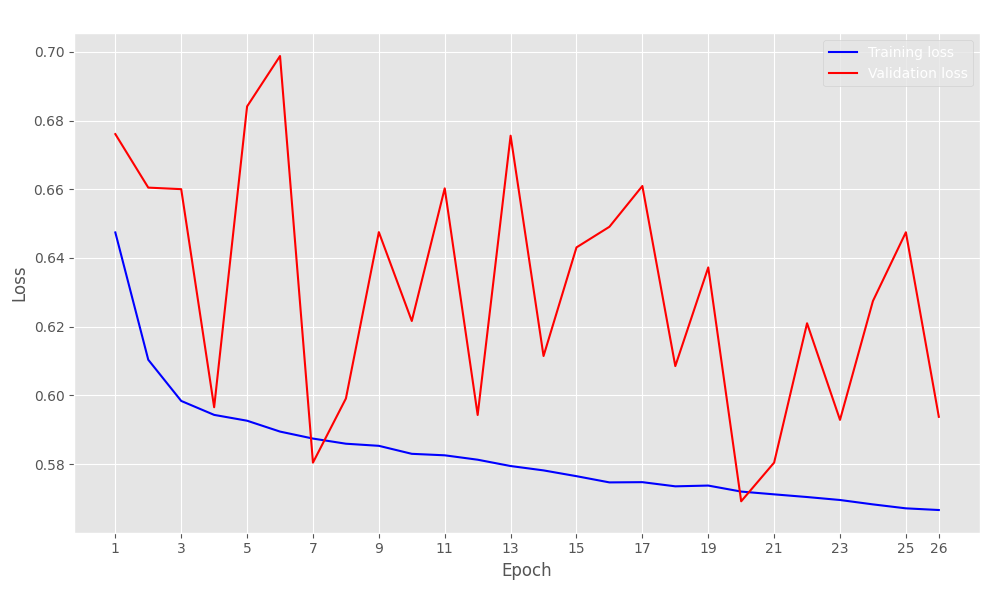

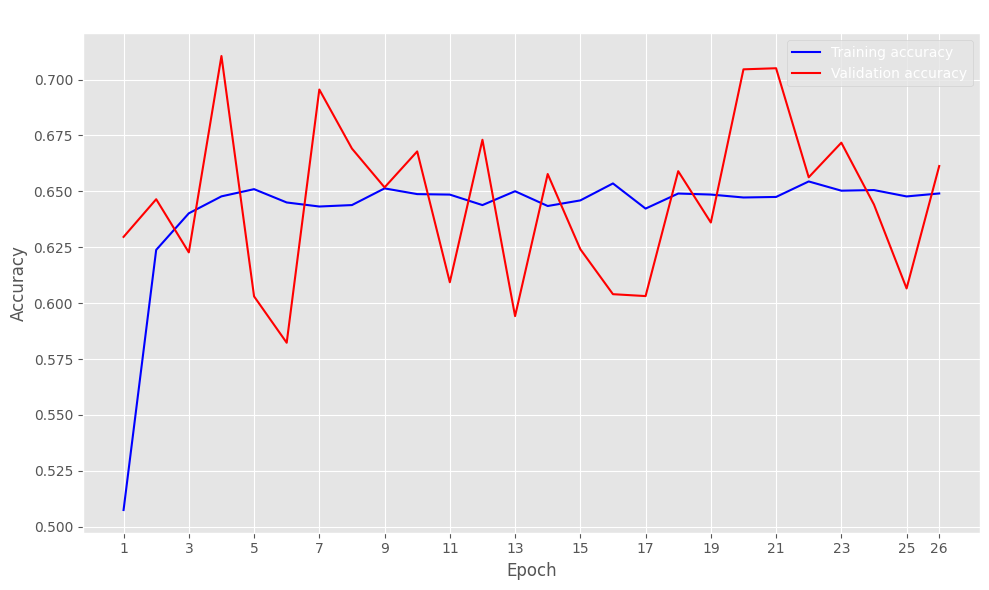

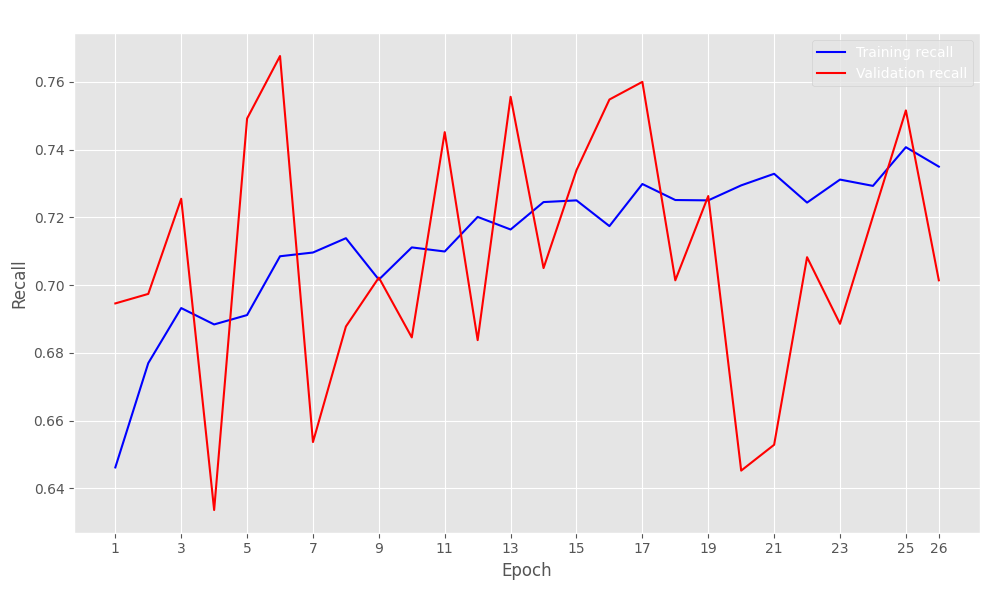

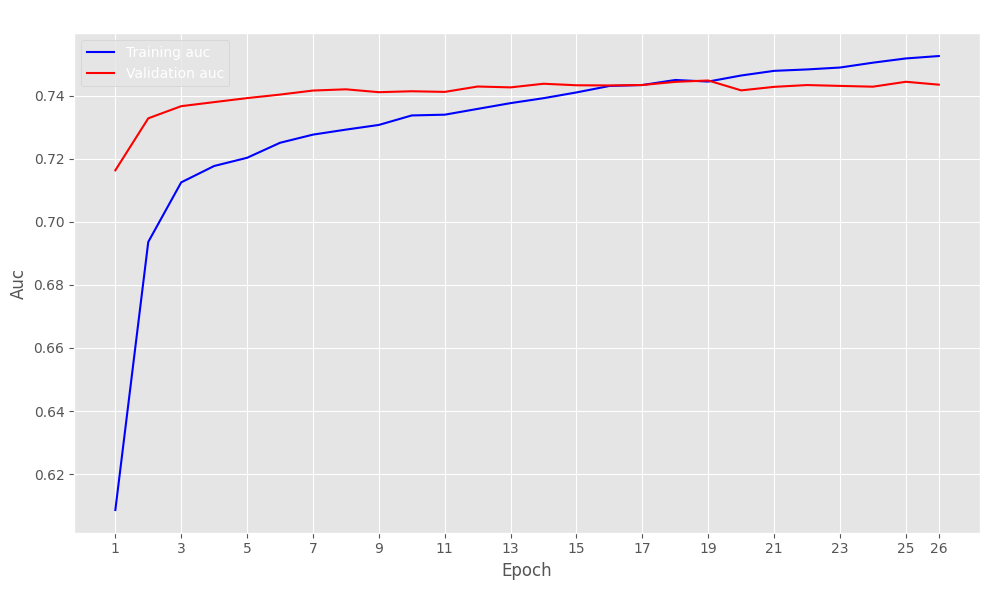

In [90]:
plot_history(history=history_bce)

In [91]:
# import keras_tuner as kt


# def build_model(hp):
#     model = Sequential()
#     model.add(Input(shape=(X_train.shape[1],)))  # Input layer

#     # Tune the number of layers and units in each layer
#     for i in range(hp.Int('num_layers', min_value=1, max_value=5)):
#         model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
#                         activation='relu'))
#         model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

#     model.add(Dense(1, activation='sigmoid'))  # Output layer

#     # Tune the learning rate
#     learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#     model.compile(
#         optimizer=Adam(learning_rate=learning_rate),
#         loss='binary_crossentropy',
#         metrics=['accuracy', Recall(name='recall'), AUC(name='auc')]
#     )
#     return model

In [92]:
# model_tune = build_model()

# history_tune = model_tune.fit(
#     X_train,
#     y_train,
#     validation_data=(X_val, y_val),
#     class_weight=class_weight_dict,
#     epochs=100,
#     batch_size=2048,
#     callbacks=[
#         EarlyStopping(
#             patience=10,
#             restore_best_weights=True,
#             monitor="val_auc",
#             mode="max",
#         ),
#     ],
# )

In [93]:
# model.save("mnist_model1.keras")

In [94]:
# from keras.models import load_model

# loaded_model = load_model("mnist_model1.keras")

preds = model_bce.predict(X_test)

# Apply a threshold to convert probabilities to classifications
threshold = 0.5  # You can adjust this threshold as needed
y_pred = (preds > threshold).astype(int)

961/961 [==============================] - 2s 2ms/step


In [95]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.63      0.76     28295
           1       0.14      0.72      0.24      2457

    accuracy                           0.64     30752
   macro avg       0.55      0.68      0.50     30752
weighted avg       0.90      0.64      0.72     30752



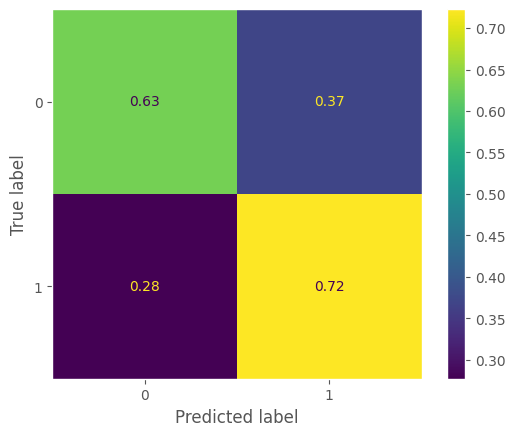

In [100]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")
plt.grid(visible=False);